In [1]:
# Load paths
path_to_features = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/diagnosis_ML4H.csv"  
path_to_date = f'/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/MumPredictPreprocessing/labels_ML4H.csv'
# Save paths
path_to_model = f"/rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/" 
path_to_figs = path_to_model + 'plots/'

import os
os.chdir('/rds/homes/g/gaddcz/Projects/mum-predict-repos/mmVAE/src/')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from wrappers import fit_restarts
import helpers

torch.manual_seed(0)
np.random.seed(0)
%matplotlib inline

# Load CPRD data
Here we load the CPRD data from outside the repository. 
We then re-order the the columns which won't affect modelling, but aids visualisation later. 
Finally we remove non-multimorbidity cases (with fewer than 2 conditions)

In [2]:
diag_frame_full = pd.read_csv(path_to_features)[helpers.get_column_order()]
diag_frame_full = diag_frame_full[diag_frame_full.sum(axis = 1) >= 2]

## Apply study specific filter
For the first study we select three (largely) clinically orthogonal conditions - asthma, cancer, and female infertility. These appear in CPRD data set with varying frequency.


As we do not know which true underlying sub-clusters are most prevalent within our data set we extract a subset of patients which belong to three medically orthogonal conditions which appear in the 


In [3]:
diag_frame, date_frame, true_label = helpers.filter_frame(diag_frame_full, verbose=0, diseases=["asthmalonglist2018","CancerAll","female_infertility"], sizes=None, remove_duplicates='first')
diag_frame.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')

N = diag_frame.shape[0]
D = diag_frame.shape[1]

# Check prevalence of diseases
print(list(zip(diag_frame.columns, diag_frame.to_numpy().sum(axis=0))))

print(f"\n We have {N} training samples, and {D} conditions")


[('CancerAll', 2890), ('asthmalonglist2018', 85395), ('female_infertility', 24125), ('AllergicRhinConj', 41236), ('migraine', 20717), ('AnxietyPTSDdiag', 26774), ('depressionDiag', 38185), ('substance_misuse', 3266), ('alcoholproblem', 1519), ('eatingdisorderuom', 3338), ('SMHmm', 3136), ('OthMental', 13196), ('OthHeadache', 7375), ('AdrenalAll', 32), ('Pituitary', 731), ('pcoskoo', 8417), ('sarcoid', 91), ('leiomyoma', 1125), ('endometriosis', 3975), ('retinal_detach', 133), ('pth', 38), ('hfincidenceprevkoo', 147), ('IHD_MI', 237), ('stroketiaincidprevkoo', 259), ('interstitiallungdiseasemm', 23), ('blindmm', 47), ('copd', 239), ('solidorgantransplant', 51), ('bronchiectasisdraftv1', 242), ('NeuroDev', 839), ('atopiceczema_mm', 7321), ('Cardiomyopathy', 69), ('cf', 82), ('sickle_cell', 34), ('PulmHtn', 12), ('ibs_mm', 15535), ('turnerssyndrome_imrd', 13), ('marfansyndrome_imrd', 39), ('HIVall', 63), ('DiabAll', 1448), ('DiabRetino', 350), ('hypertension', 2108), ('spina_bifida', 192)

/rds/homes/g/gaddcz/Projects/mmVAE/src/helpers.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c["label"] = (c+1) * np.ones_like(df_c.index.values)


## Get disjoint testing set, to test generalisation to out-of-distribution data
We first get all depression cases as a testing set, then remove all patients that were used for training.

In [4]:
# Out-of-distribution data
diag_frame_test, _, _ = helpers.filter_frame(diag_frame_full, verbose=0, diseases=["depressionDiag"], sizes=None, remove_duplicates='first')
diag_frame_exc, _, _ = helpers.filter_frame(diag_frame_full, verbose=0, diseases=["asthmalonglist2018","CancerAll","female_infertility"], sizes=None, remove_duplicates='first')
drop_ind = [ind for ind in diag_frame_exc.index if ind in diag_frame_test.index]                       # Get indices common to both
diag_frame_test.drop(drop_ind, inplace=True)
diag_frame_test.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
Y_test = diag_frame_test.to_numpy()

# Check prevalence of diseases
print(list(zip(diag_frame_test.columns, diag_frame_test.to_numpy().sum(axis=0))))
# print(diag_frame_test.columns[diag_frame_test.to_numpy().sum(axis=0)>4500])

print(f"\n We have {Y_test.shape[0]} out of distribution test samples, and {Y_test.shape[1]} conditions")


[('CancerAll', 0), ('asthmalonglist2018', 0), ('female_infertility', 0), ('AllergicRhinConj', 19414), ('migraine', 18190), ('AnxietyPTSDdiag', 48503), ('depressionDiag', 94905), ('substance_misuse', 5527), ('alcoholproblem', 2748), ('eatingdisorderuom', 4846), ('SMHmm', 6272), ('OthMental', 22381), ('OthHeadache', 7001), ('AdrenalAll', 6), ('Pituitary', 427), ('pcoskoo', 4698), ('sarcoid', 65), ('leiomyoma', 645), ('endometriosis', 2647), ('retinal_detach', 104), ('pth', 33), ('hfincidenceprevkoo', 69), ('IHD_MI', 158), ('stroketiaincidprevkoo', 272), ('interstitiallungdiseasemm', 8), ('blindmm', 33), ('copd', 44), ('solidorgantransplant', 38), ('bronchiectasisdraftv1', 42), ('NeuroDev', 729), ('atopiceczema_mm', 3260), ('Cardiomyopathy', 44), ('cf', 49), ('sickle_cell', 26), ('PulmHtn', 6), ('ibs_mm', 14677), ('turnerssyndrome_imrd', 9), ('marfansyndrome_imrd', 26), ('HIVall', 67), ('DiabAll', 1280), ('DiabRetino', 412), ('hypertension', 1677), ('spina_bifida', 180), ('CongHeart', 635

# t-SNE visualisaton of orthogonal training data
In comparison to the t-SNE visualisation on the full dataset (see paper Appendix or study 2 notebook), where no clustering structure can be observed at all, after filtering we now observe three distinct clusters. However, even with carefully curated subsets like this, the complex structure of multimorbidity remains. We will observe this later.

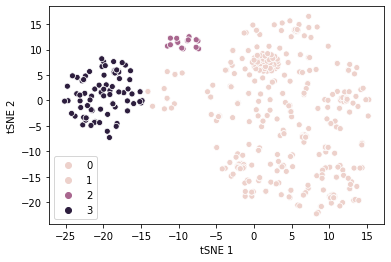

In [5]:
YtSNE = diag_frame.sample(n=500, random_state=1, replace=False)
latentTSNE = TSNE(n_components=2, init='random').fit_transform(YtSNE)

tSNE = pd.DataFrame(latentTSNE, columns=['tSNE 1', 'tSNE 2'], index=YtSNE.index)
sns.scatterplot(data = tSNE, x = "tSNE 1", y = "tSNE 2", hue=true_label[YtSNE.index]);  
plt.show()

# print(tSNE.head())

# Define model parameterisation and architecture

In [6]:
L = 16
architecture = {'enc_h': [D, D, D, L], 
                'dec_h': [L, D, D, D], 
                'constrain': ['L0', 'L0'],
               }
model_params = {'tmp_schedule': [4, 0.4, 0.4],
                 'epochs': 50,
                 'batch_size': 256,
                 'lr': 5e-3,
                 'verbose': 1,
                 'anneal': True,
                }

# Run experiment

We train for multiple $\beta$ values, with multiple restarts. This is **not** due to local minima, but to analayse how clustering differs across seeds. As $\beta$ increases (and particularly when it is positive) this demonstrates how the clustering degrades.

Regardless, we take the seed with the smallest loss. However, smallest loss does not necessarily mean better clustering here.

Plot order
* the prevalence of each condition in each quantised cluster
* the odds ratio (truncated to have maximum value $5$) of each quantised cluster
* the cluster factor association matrix
* the prevalence within factors
* the odds ratio within factors
* the test data factor and cluster (labelled by how prevalent these unique factor combinations were in training) prevalence 
* the test data factor odds ratio


For demonstration, we consider multiple cases. 
* $\hat{\beta} = [-1, -0.4]$ 
* $\hat{\beta} = 0$ (auto-encoder with no entropy term attached)
* $\hat{\beta} = 0.1$ is the original positive formulation which maximises latent uncertainty (pushing latent values towards $0.5$).



Normalised beta=-1
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg1_00_0.pickle, training...
====> Training Epoch: 1 Train loss: 2.316 (Reconstruction loss:2.31640 and entropy:5.59379). Temperature 4.0. kl_anneal: 0.00
	====> Validating: Validation loss: 17.248 (Reconstruction loss:1.43356 and entropy: 3.20286). Temperature 0.4. kl_anneal: 1
====> Training Epoch: 2 Train loss: 1.253 (Reconstruction loss:1.25342 and entropy:2.31652). Temperature 3.8. kl_anneal: 0.00
====> Training Epoch: 3 Train loss: 1.152 (Reconstruction loss:1.15192 and entropy:1.90815). Temperature 3.6. kl_anneal: 0.00
====> Training Epoch: 4 Train loss: 1.026 (Reconstruction loss:1.02604 and entropy:1.53403). Temperature 3.5. kl_anneal: 0.00
====> Training Epoch: 5 Train loss: 0.938 (Reconstruction loss:0.93787 and entropy:1.29694). Temperature 3.3. kl_anneal: 0.00
====> Training Epoch: 6 Train loss: 0.829 (Recon

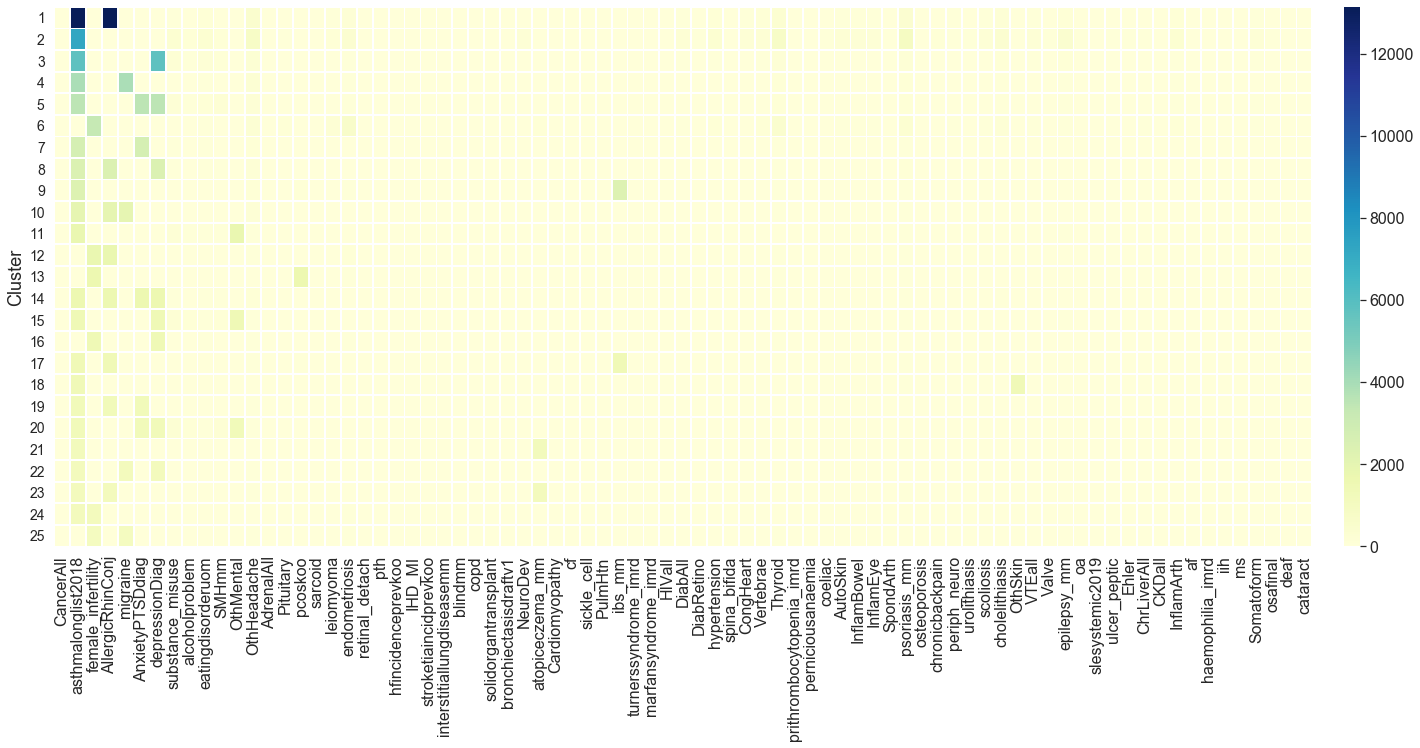

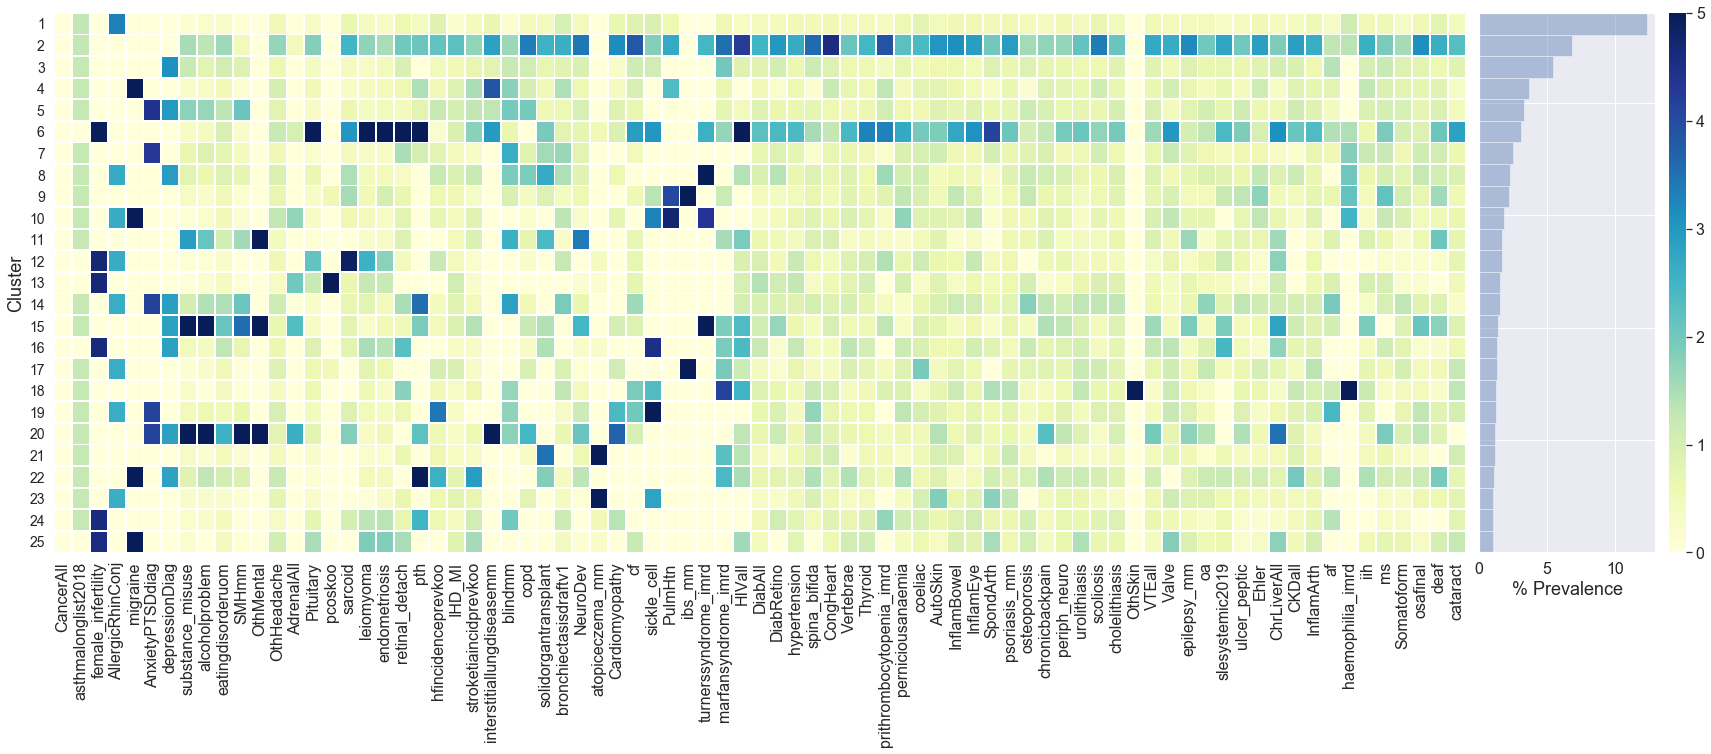

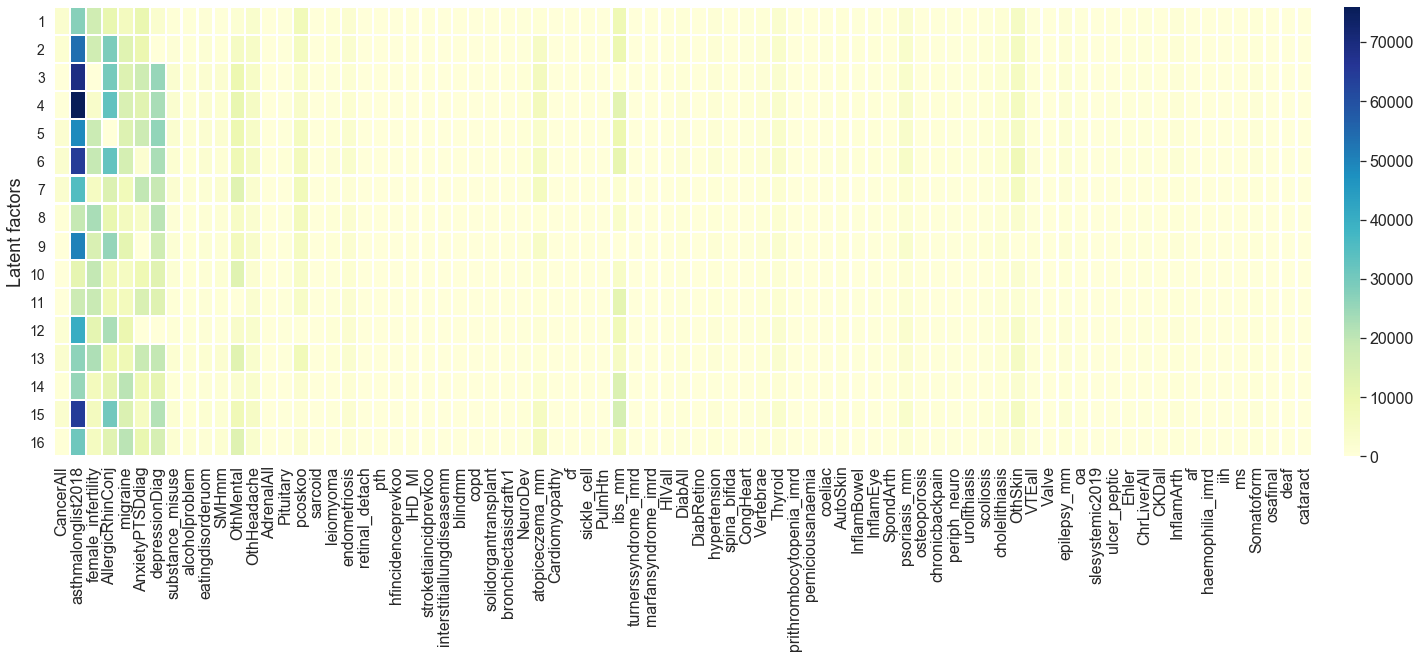

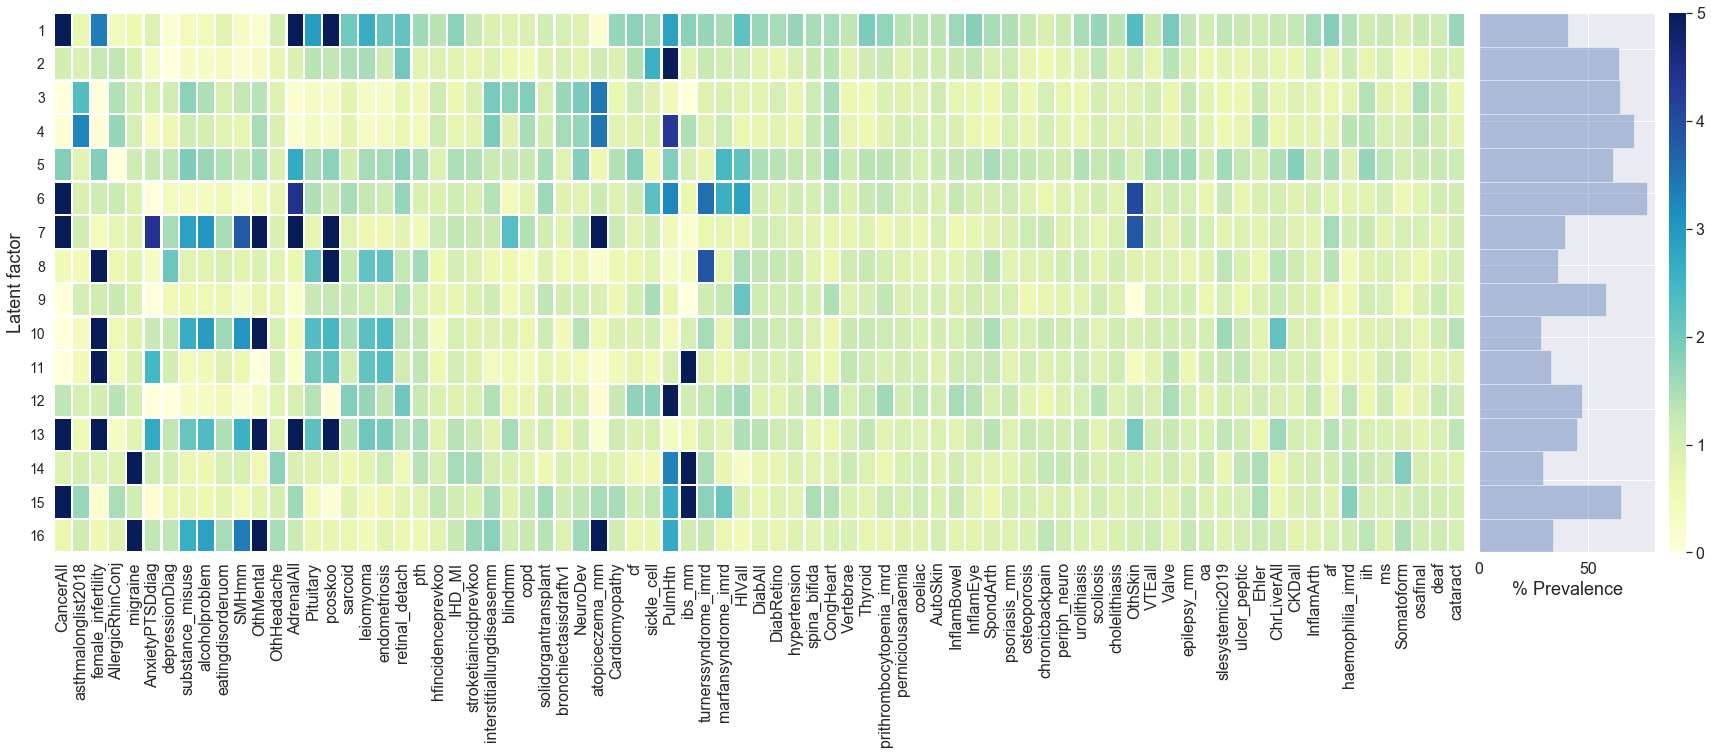

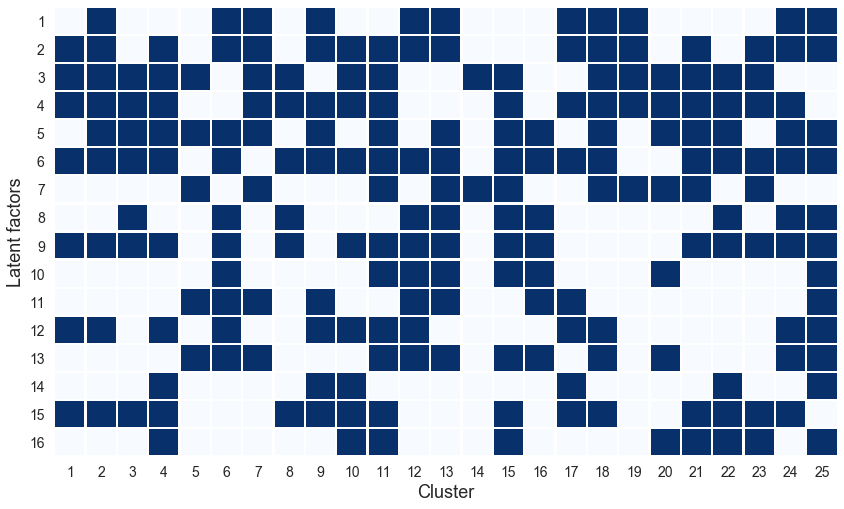

/rds/bear-apps/2019b/EL8-has/software/PyTorch/1.4.0-foss-2019b-Python-3.7.4/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


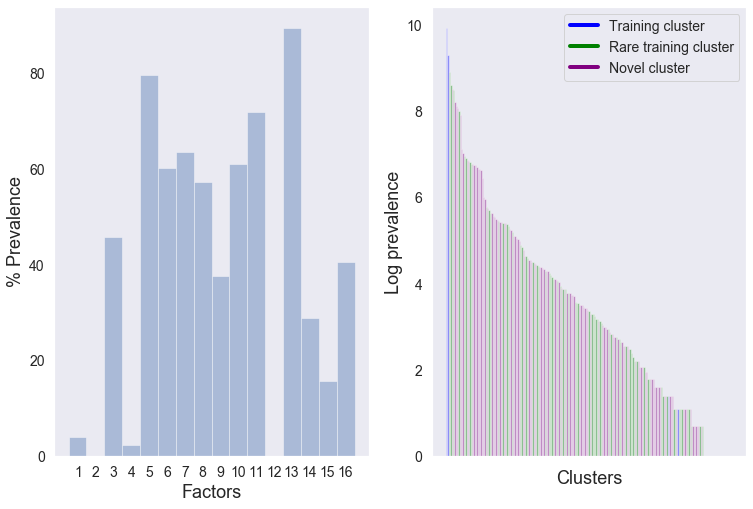

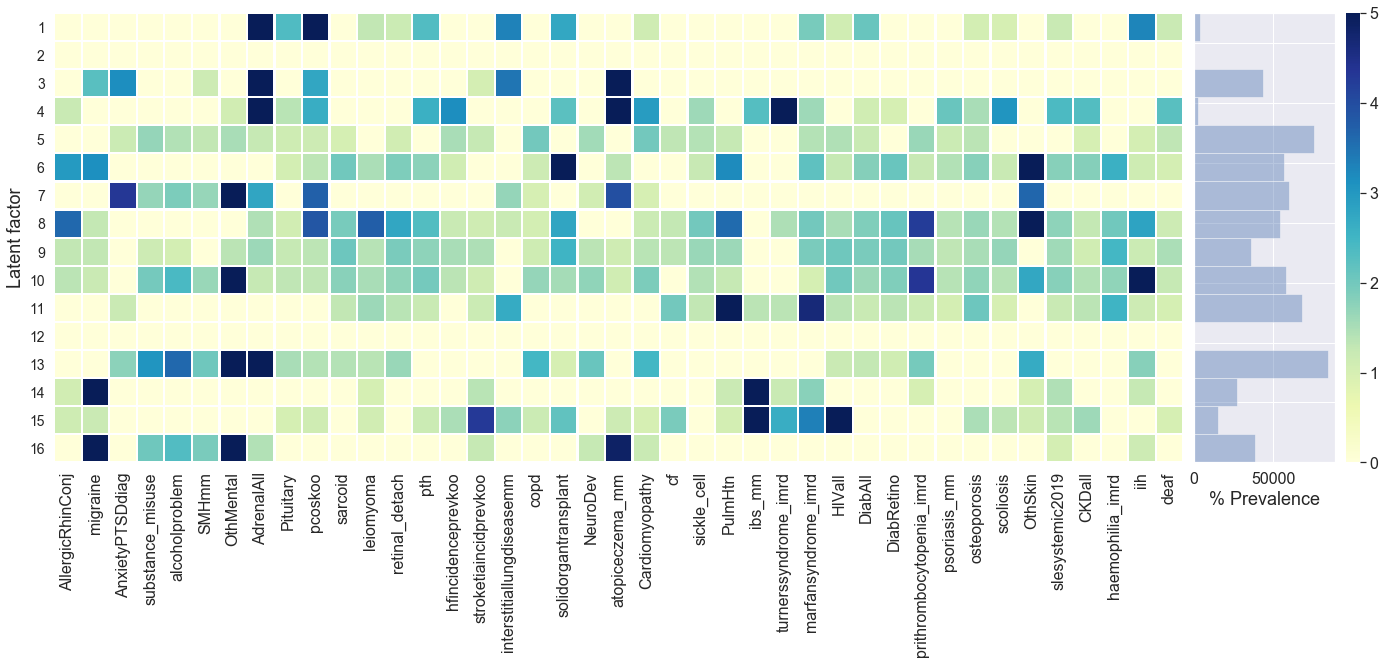

Saving best seed clustering for normalised beta -1 at /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg1_00_1


Normalised beta=-0.4
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg0_40_0.pickle, training...
====> Training Epoch: 1 Train loss: 2.350 (Reconstruction loss:2.34998 and entropy:5.49729). Temperature 4.0. kl_anneal: 0.00
	====> Validating: Validation loss: 7.664 (Reconstruction loss:1.44818 and entropy: 3.14724). Temperature 0.4. kl_anneal: 1
====> Training Epoch: 2 Train loss: 1.367 (Reconstruction loss:1.36739 and entropy:2.58441). Temperature 3.8. kl_anneal: 0.00
====> Training Epoch: 3 Train loss: 1.277 (Reconstruction loss:1.27662 and entropy:2.29708). Temperature 3.6. kl_anneal: 0.00
====> Training Epoch: 4 Train loss: 1.113 (Reconstruction loss:1.11346 and entropy:2.10660). Temperature

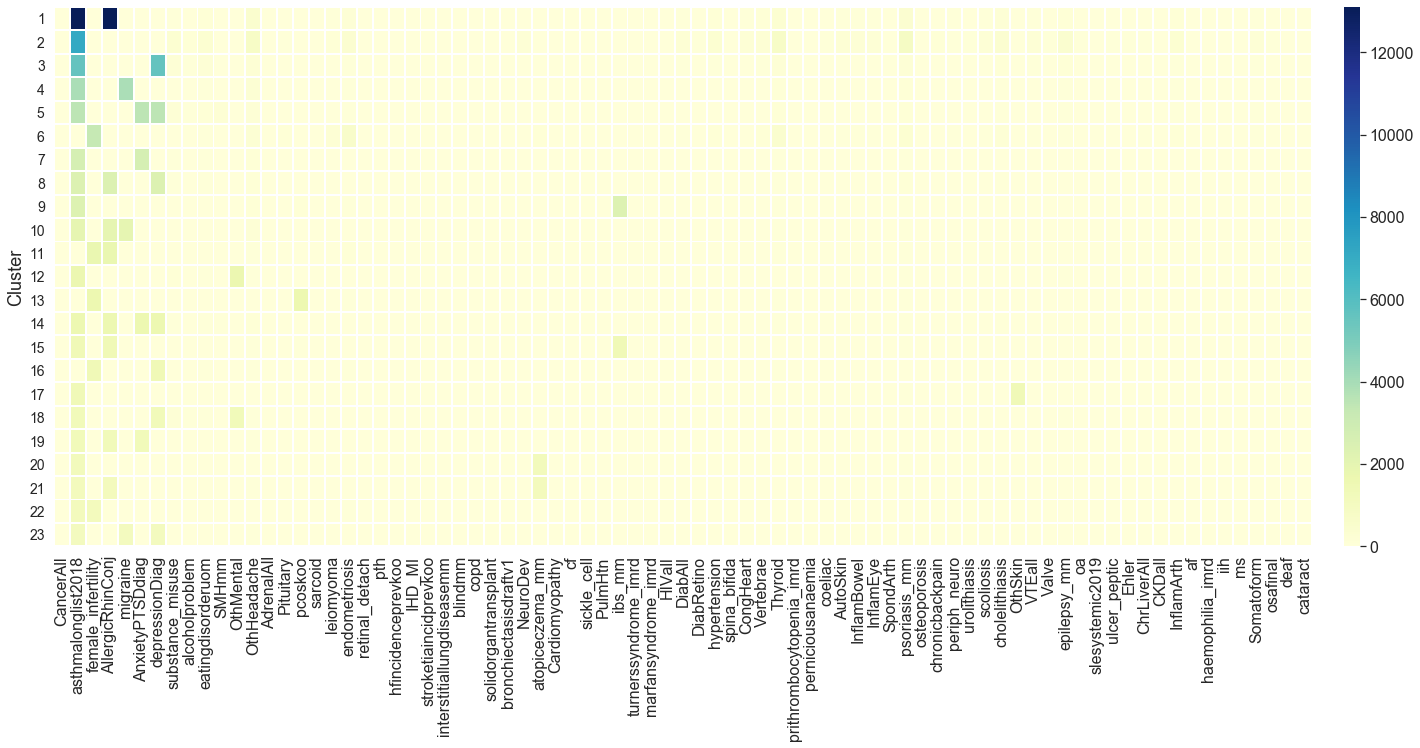

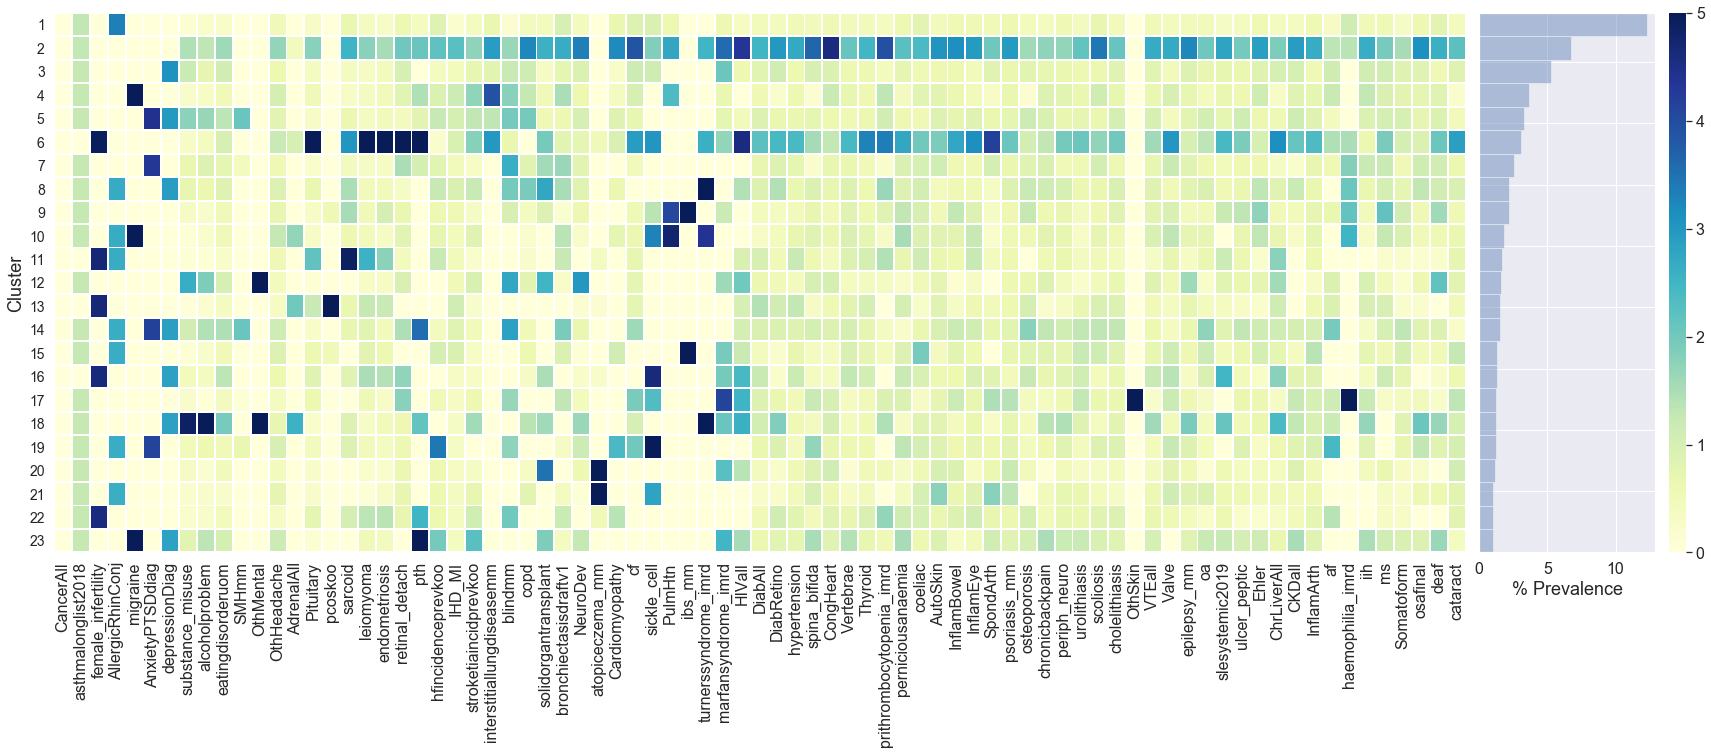

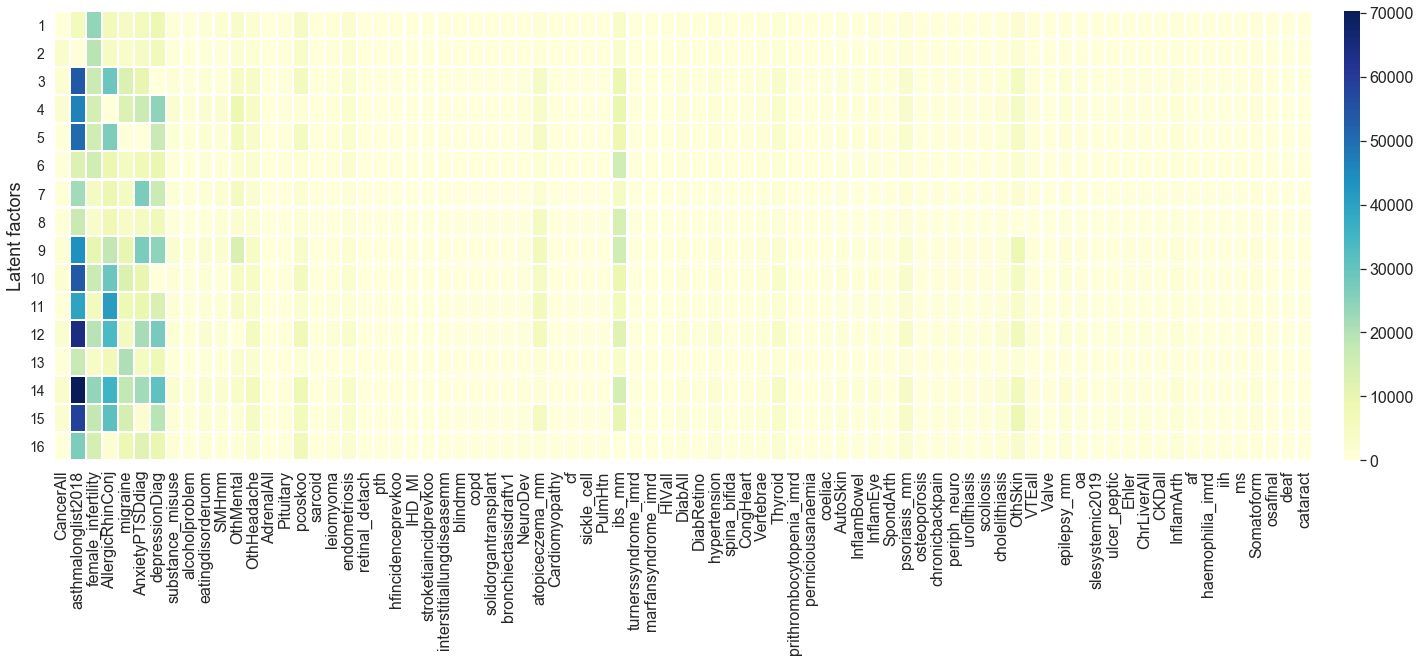

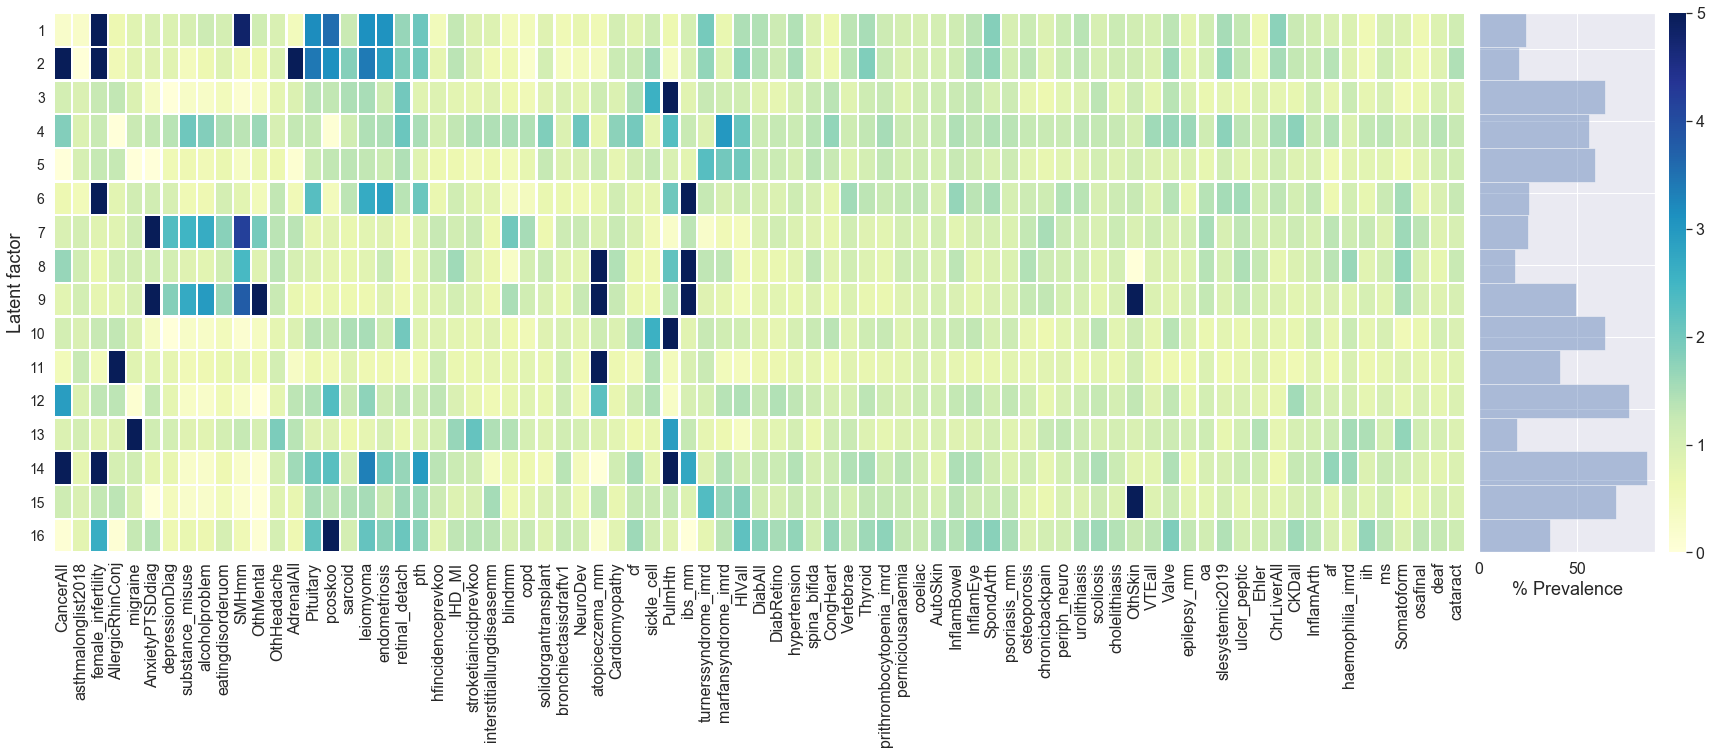

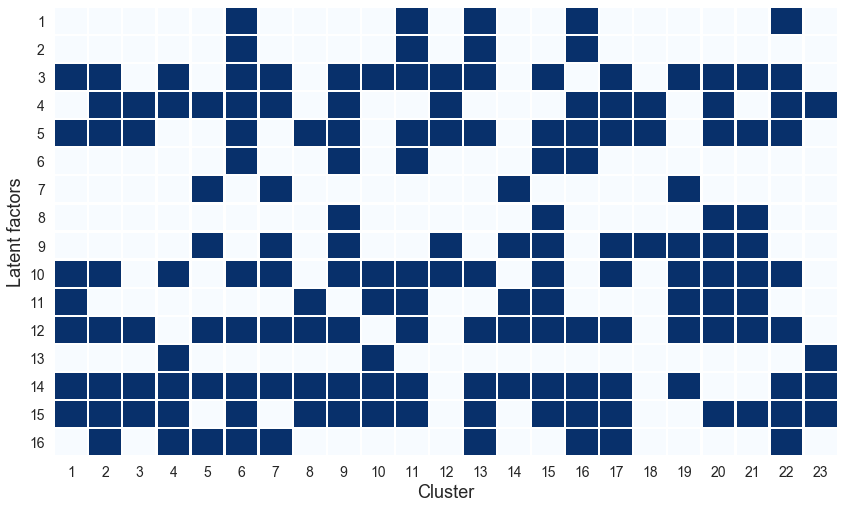

/rds/bear-apps/2019b/EL8-has/software/PyTorch/1.4.0-foss-2019b-Python-3.7.4/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


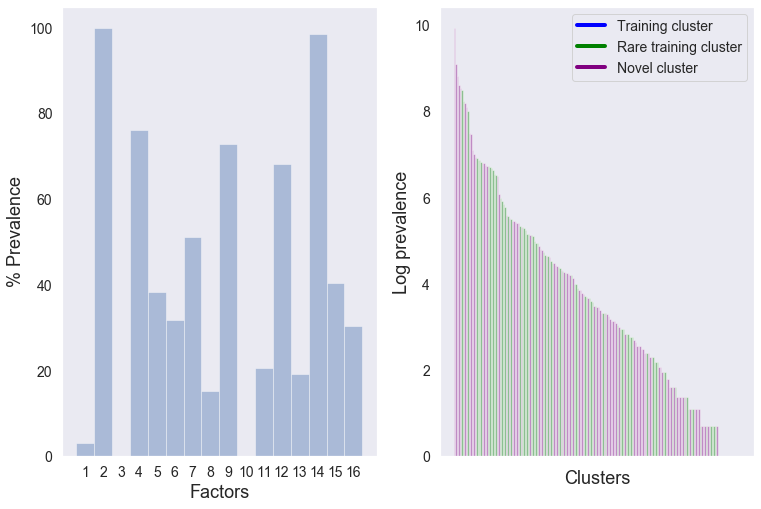

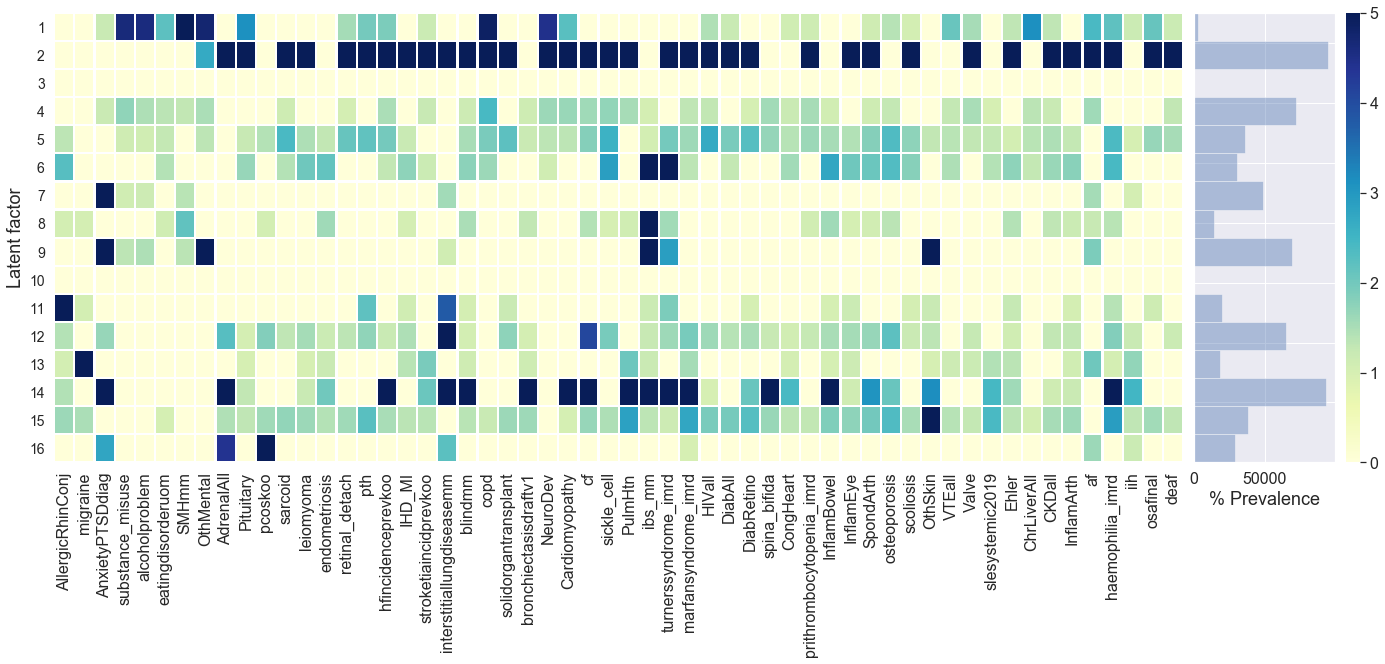

Saving best seed clustering for normalised beta -0.4 at /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_BetaNeg0_40_2


Normalised beta=0
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_Beta0_00_0.pickle, training...
====> Training Epoch: 1 Train loss: 2.385 (Reconstruction loss:2.38501 and entropy:5.93022). Temperature 4.0. kl_anneal: 0.00
	====> Validating: Validation loss: 1.502 (Reconstruction loss:1.50176 and entropy: 3.76578). Temperature 0.4. kl_anneal: 1
====> Training Epoch: 2 Train loss: 1.265 (Reconstruction loss:1.26486 and entropy:2.87667). Temperature 3.8. kl_anneal: 0.00
====> Training Epoch: 3 Train loss: 1.143 (Reconstruction loss:1.14262 and entropy:2.19698). Temperature 3.6. kl_anneal: 0.00
====> Training Epoch: 4 Train loss: 1.034 (Reconstruction loss:1.03381 and entropy:1.92702). Temperature 3.5

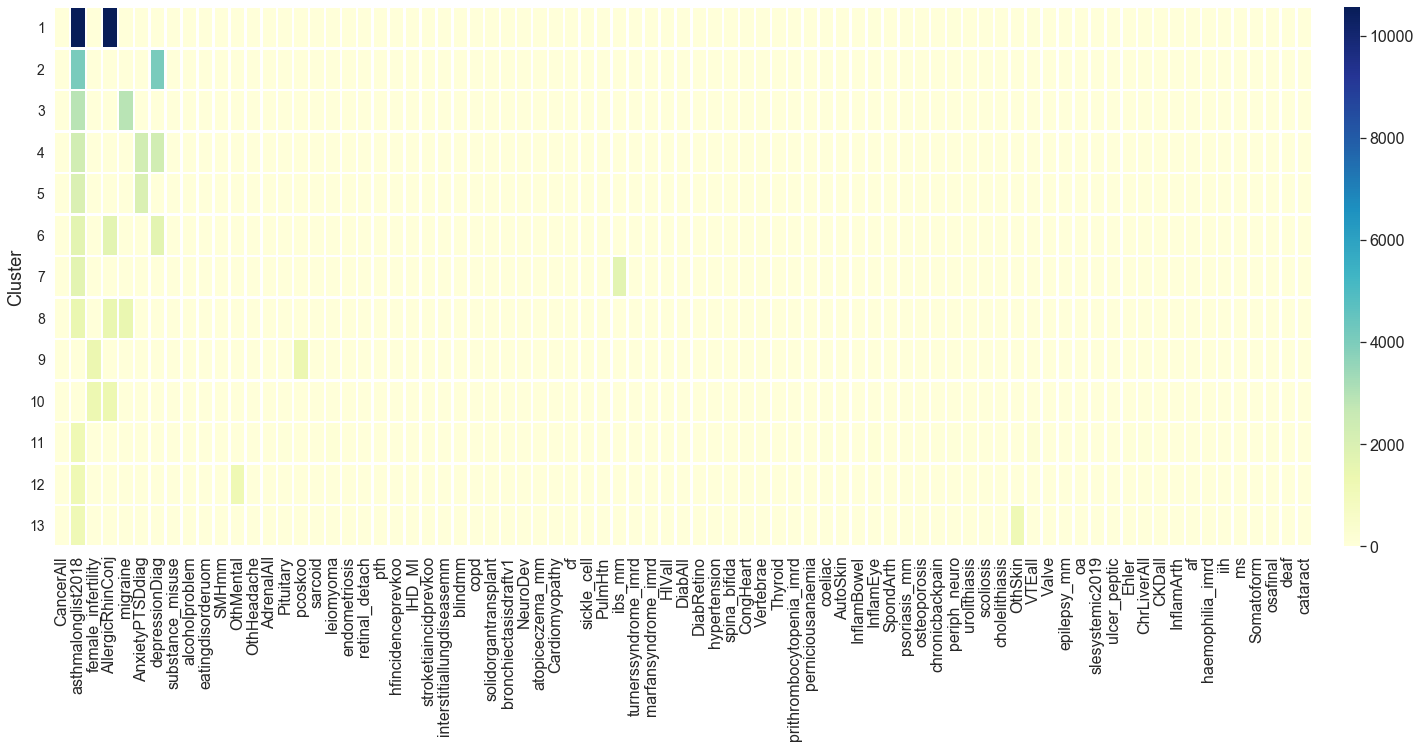

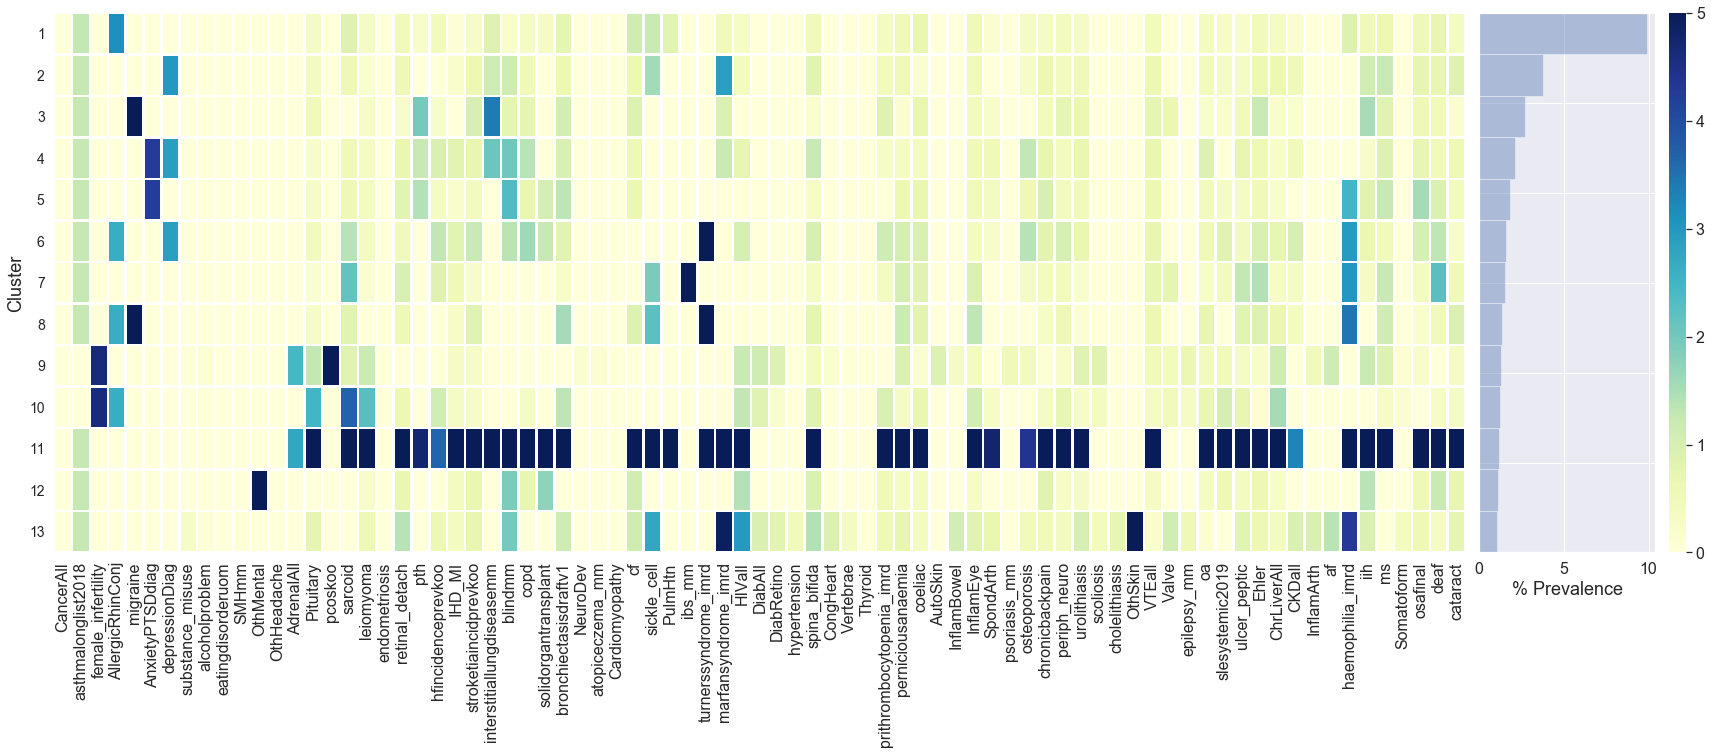

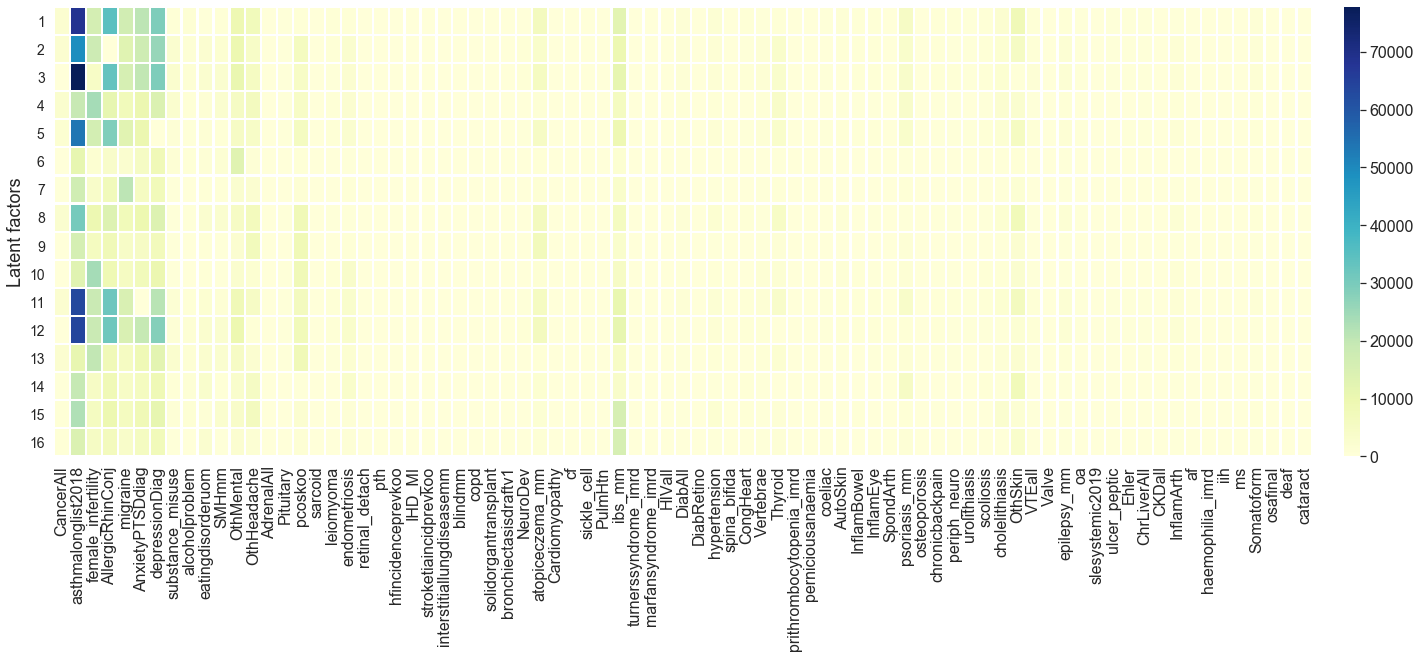

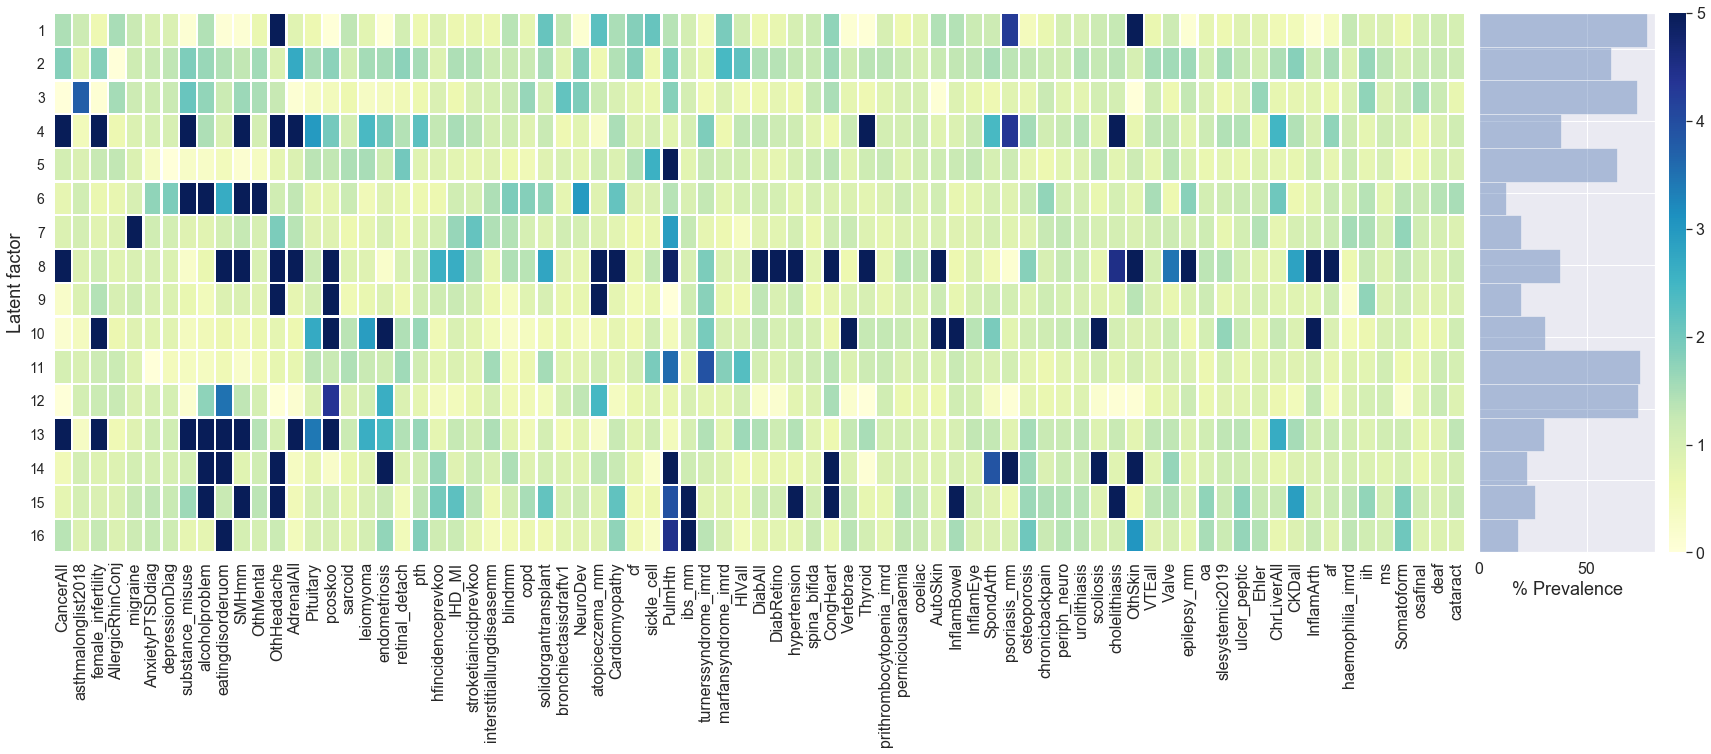

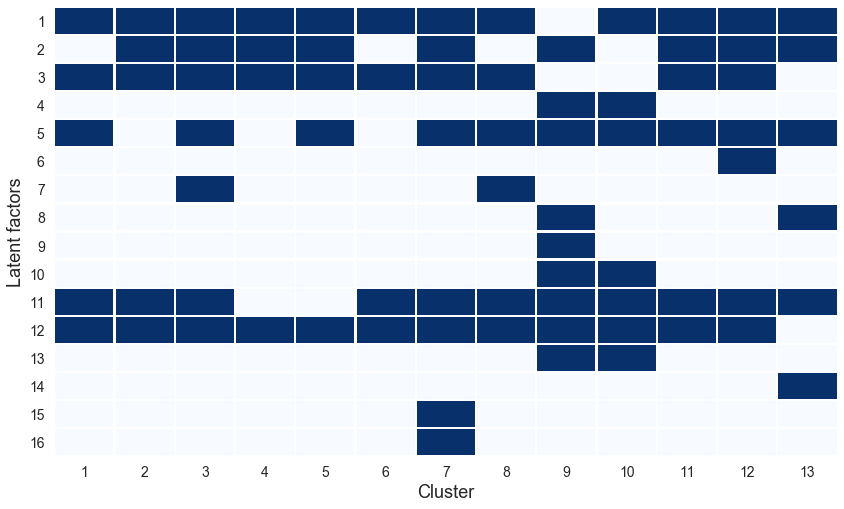

/rds/bear-apps/2019b/EL8-has/software/PyTorch/1.4.0-foss-2019b-Python-3.7.4/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


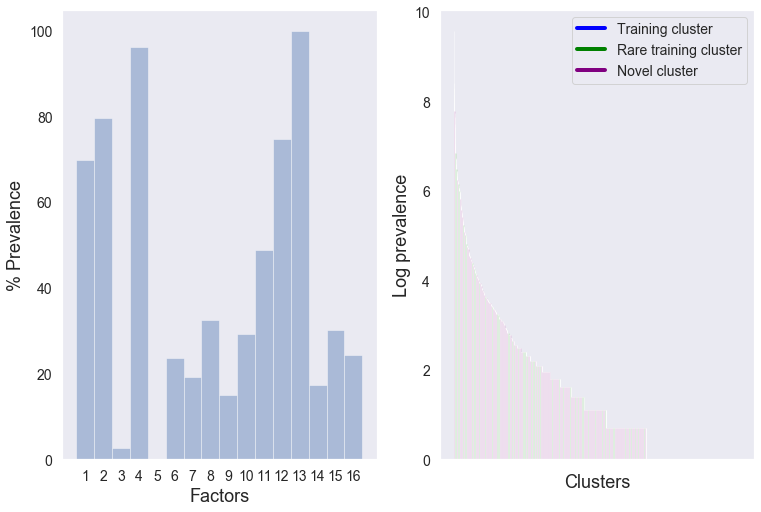

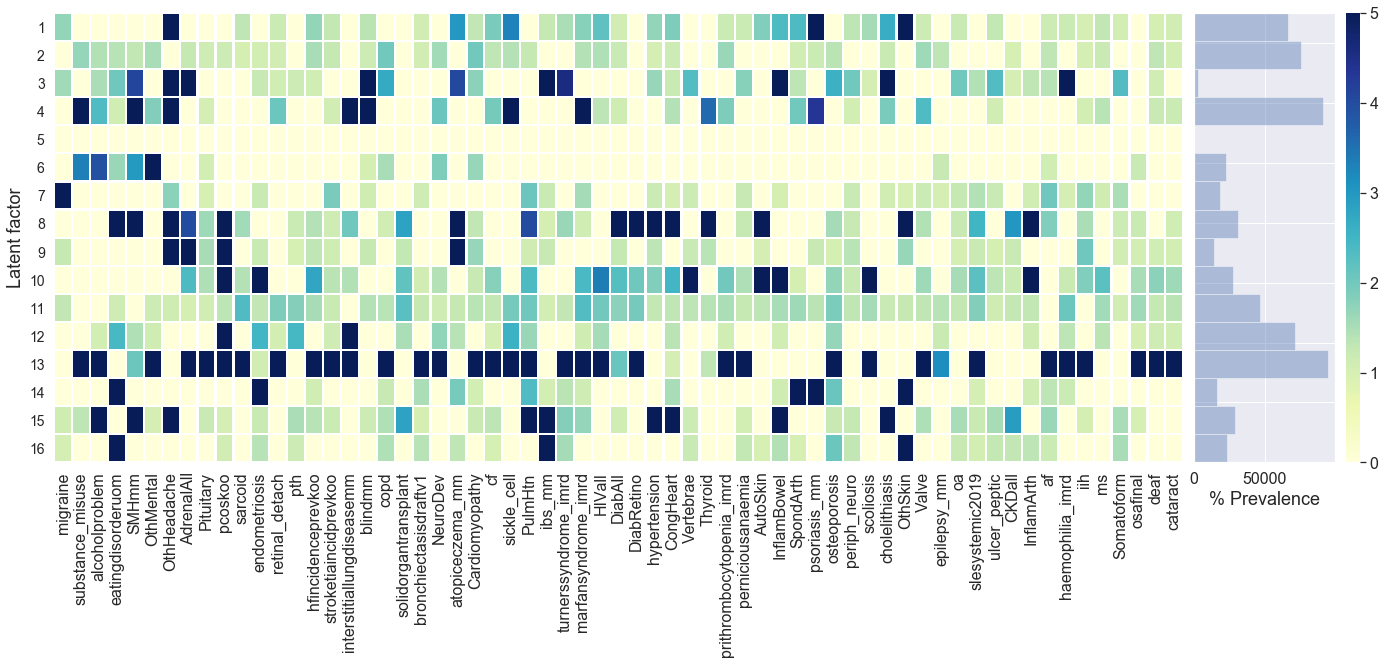

Saving best seed clustering for normalised beta 0 at /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_Beta0_00_1


Normalised beta=0.1
Failed to load /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_Beta0_10_0.pickle, training...
====> Training Epoch: 1 Train loss: 2.397 (Reconstruction loss:2.39686 and entropy:5.90023). Temperature 4.0. kl_anneal: 0.00
	====> Validating: Validation loss: -0.141 (Reconstruction loss:1.43944 and entropy: 3.20105). Temperature 0.4. kl_anneal: 1
====> Training Epoch: 2 Train loss: 1.276 (Reconstruction loss:1.27594 and entropy:2.59791). Temperature 3.8. kl_anneal: 0.00
====> Training Epoch: 3 Train loss: 1.177 (Reconstruction loss:1.17651 and entropy:1.98328). Temperature 3.6. kl_anneal: 0.00
====> Training Epoch: 4 Train loss: 1.062 (Reconstruction loss:1.06236 and entropy:1.58638). Temperature 3.5. k

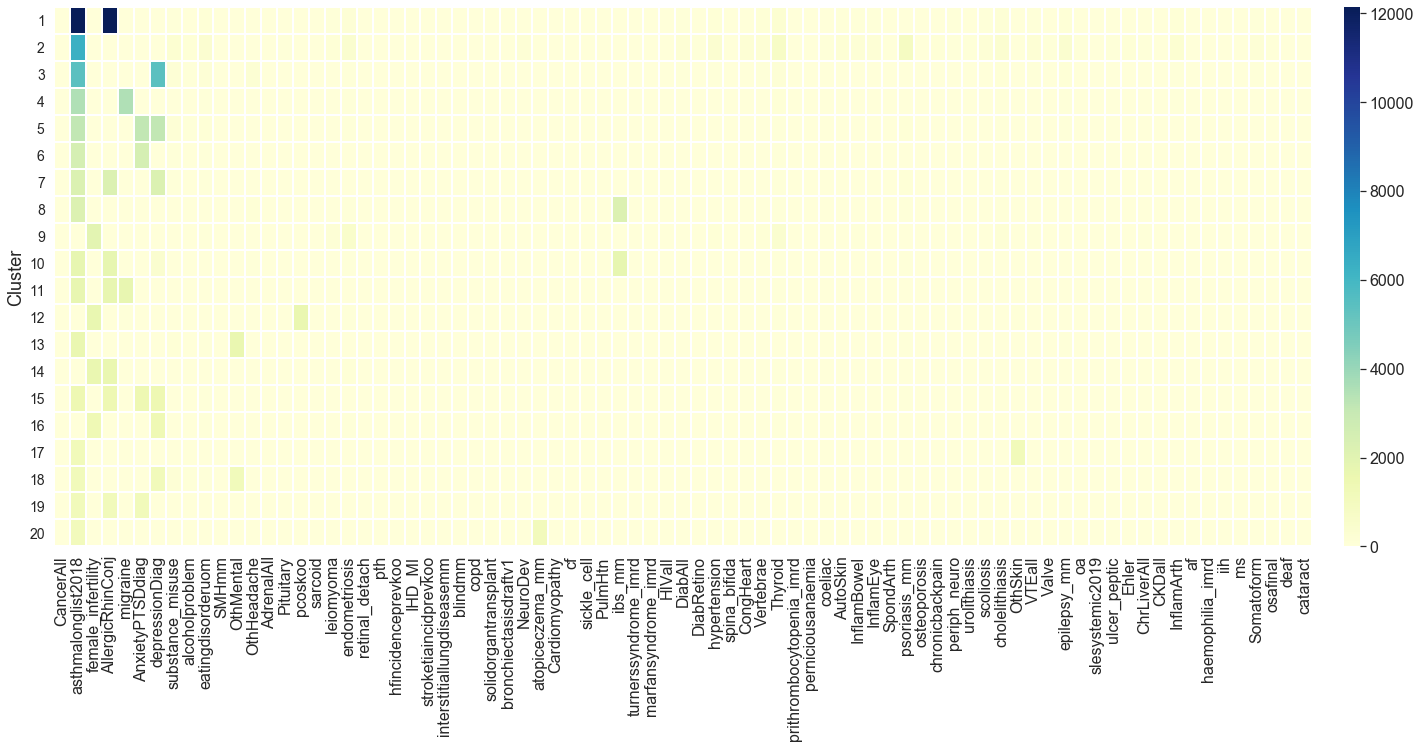

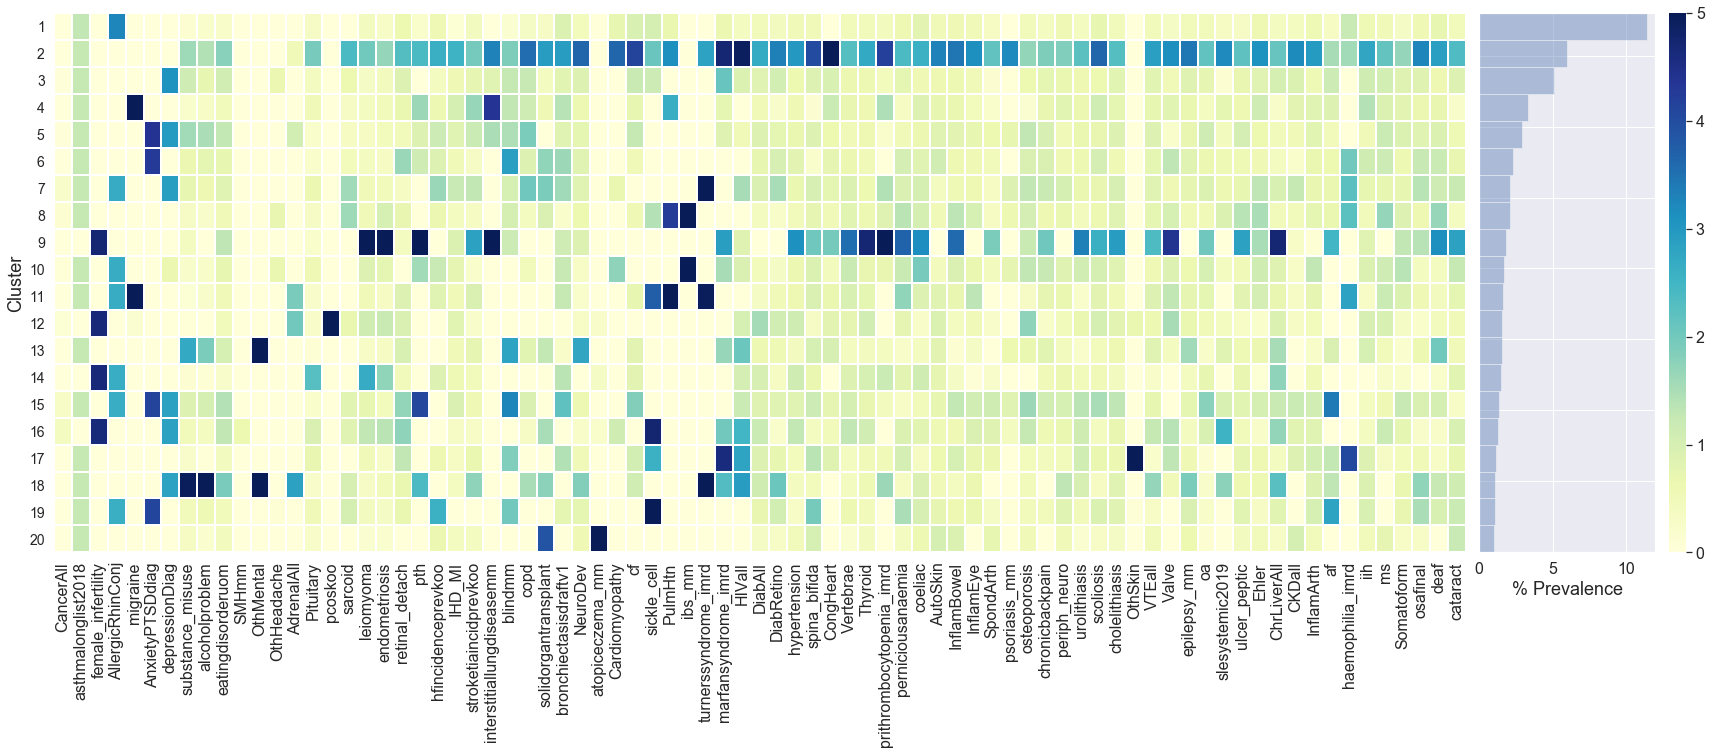

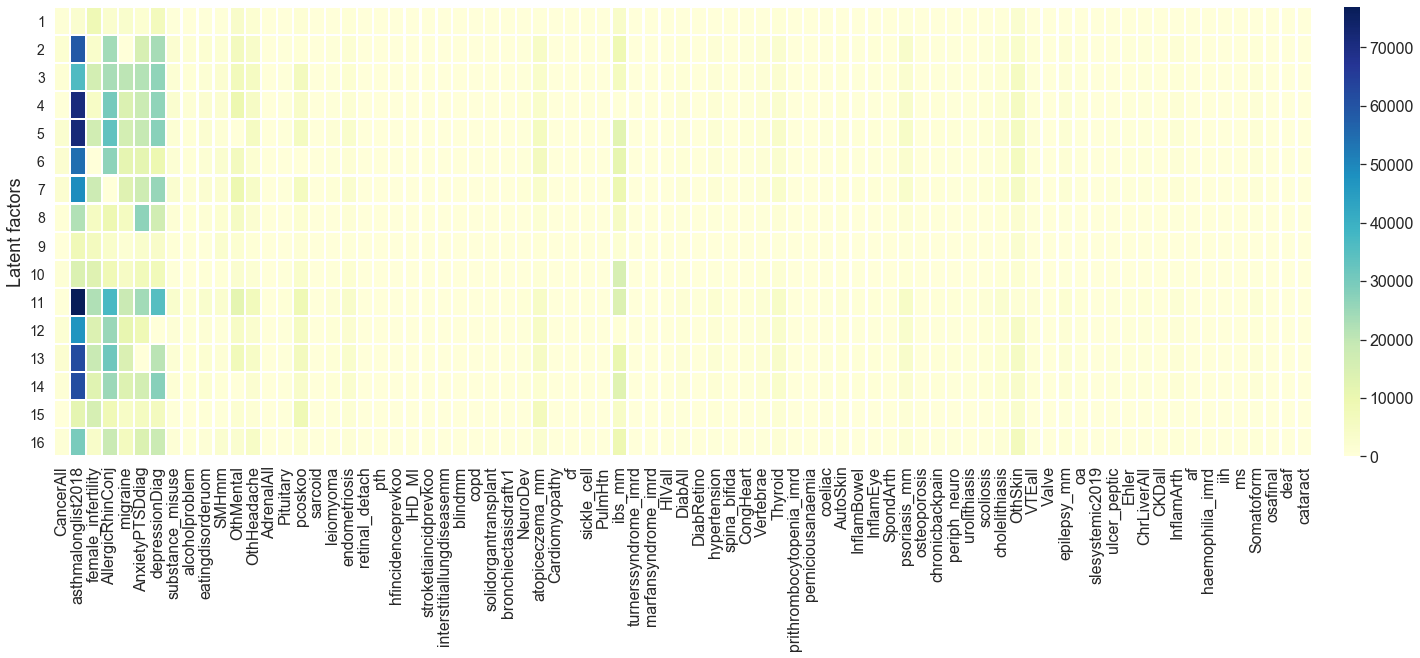

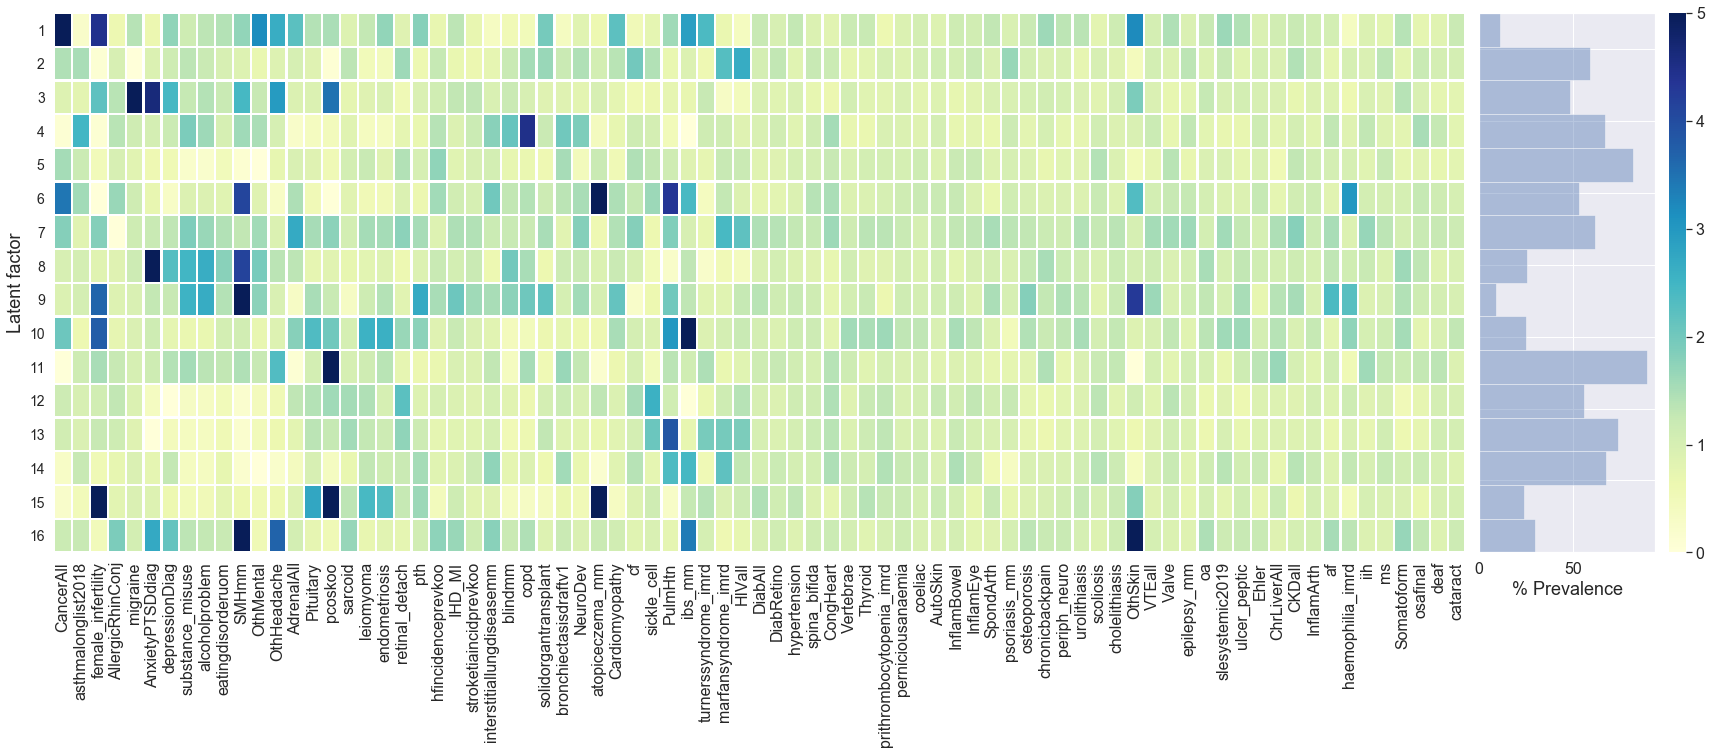

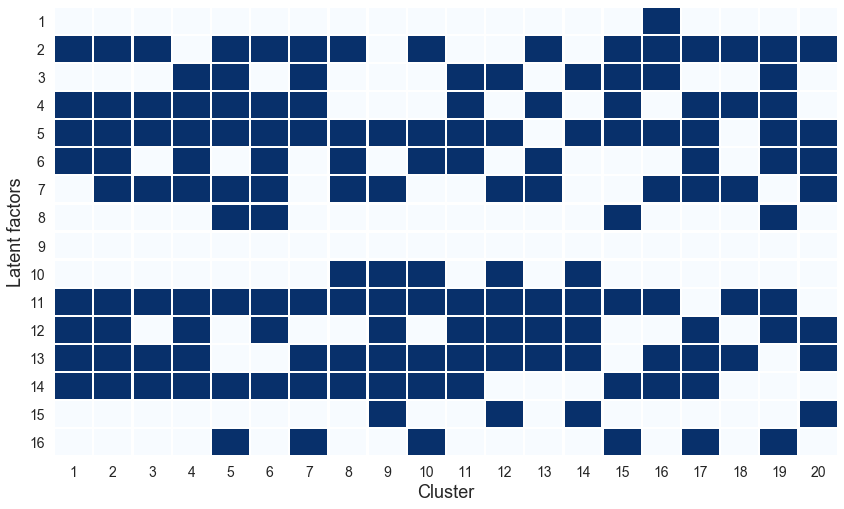

/rds/bear-apps/2019b/EL8-has/software/PyTorch/1.4.0-foss-2019b-Python-3.7.4/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


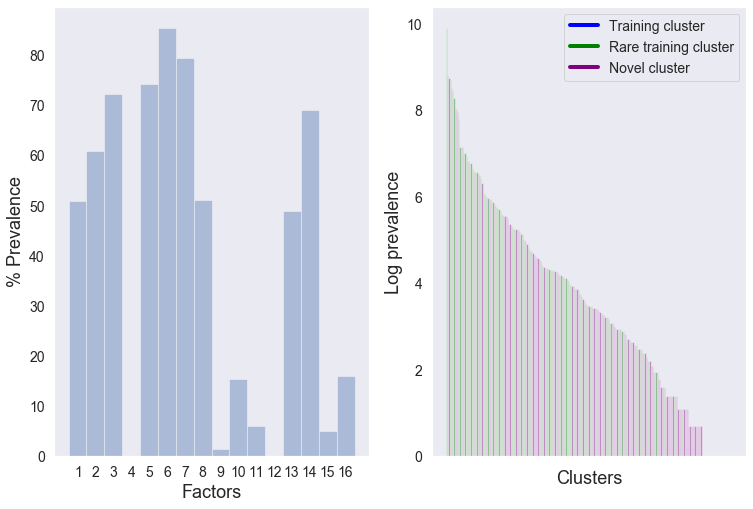

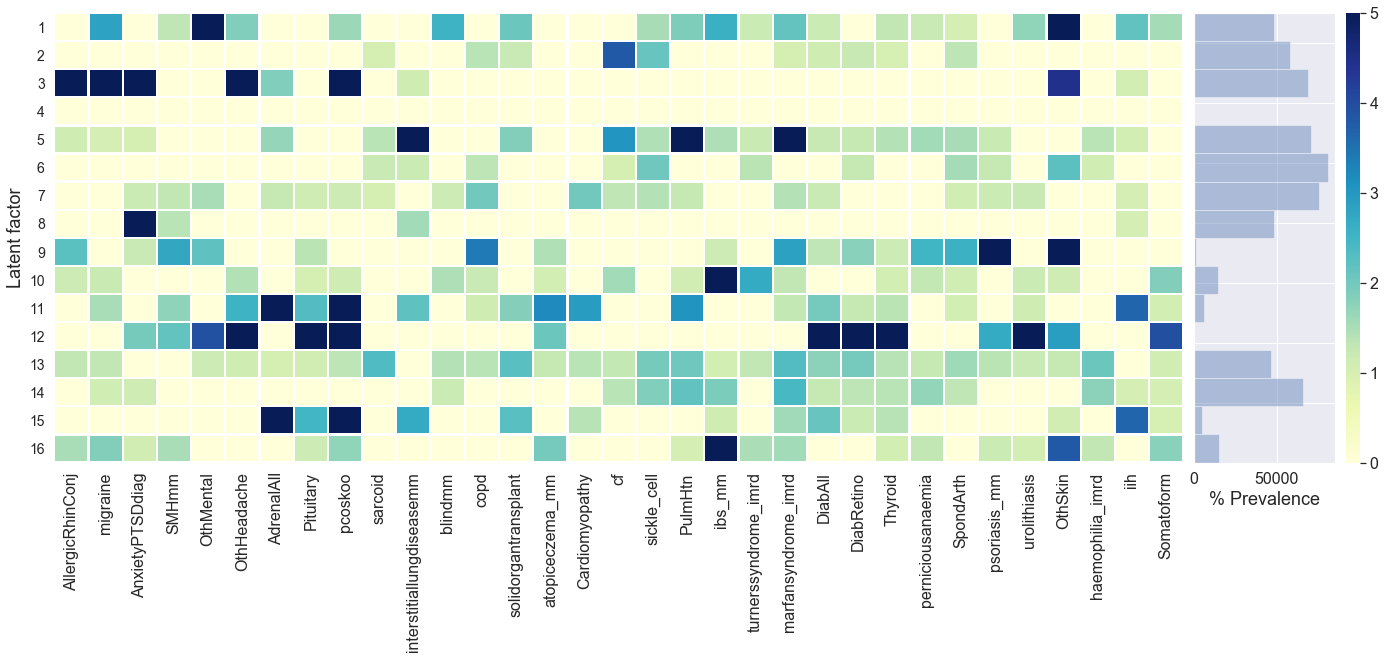

Saving best seed clustering for normalised beta 0.1 at /rds/projects/s/subramaa-mum-predict/CharlesGadd_Oxford/mmVAE_ML4HSubmission_ModelsAndFigures_mod/study2_L16_alldata/Bernoulli_Beta0_10_1


In [7]:
betas = [-1, -0.4, 0, 0.1] # np.hstack((np.linspace(-2,0,11), np.linspace(0.05, 0.4, 8)))

dicts, avg_amis = [], []
for norm_beta in betas:
    print(f"\n\n====================\nNormalised beta={norm_beta}\n====================")
    
    model_params['norm_beta'] = norm_beta
    method_name = f'Bernoulli_Beta{norm_beta:.2f}'.replace(".", "_").replace("-", "Neg")

    all_dicts, losses, labels, avg_ami = fit_restarts(diag_frame, architecture, model_params,
                                                      n_restarts=3,
                                                      save_path=f"{path_to_model}{method_name}",
                                                      force_retrain=False
                                                      )

    best_dict, best_path = plot_restarts(diag_frame, all_dicts, losses, labels,
                                          Y_test=Y_test, 
                                          yaxis_scale=1.2, plot_threshold_frac=0.01, 
                                          save_path=f"{path_to_model}{method_name}",
                                          plot_path=f"{path_to_figs}{method_name}",
                                          log_odds=True, vmin=0, vmax=None,
                                         )
    
    print(f"Saving best seed clustering for normalised beta {norm_beta} at {best_path}")
    np.savetxt(best_path + "cluster_allocations.txt", best_dict['cluster_allocations'])
    np.savetxt(best_path + "factors.txt", best_dict['z_binary'])
    avg_amis.append(avg_ami)
    


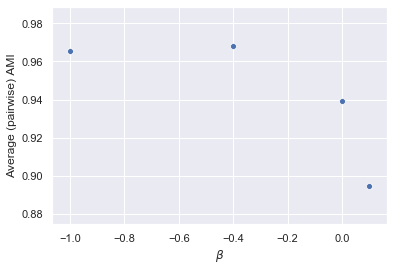

In [9]:
sns.scatterplot(betas[:len(avg_amis)], avg_amis); 
plt.xlabel(r"$\beta$")
plt.ylabel("Average (pairwise) AMI")
plt.show()